# Keras based GRU Network

## Prepare dataset

Reformat dataset to be int format
```
caption | valence_class
caption | {negative,neutral,positive}
```

In [1]:
import os, sys, io,re, string, pathlib, random
from collections import Counter, OrderedDict

import hecutils.data_utils as dt
import hecutils.scoring_utils as sc
import hecutils.plotting_utils as pt
import hecutils.caption_utils as caput
import hecutils.image_utils as imut


import tensorflow as tf
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.layers import Dense, Conv1D, MaxPooling1D, GRU, Bidirectional, LSTM
from keras.layers.core import Dropout, Flatten, Masking, ActivityRegularization
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import plot_model
from keras import regularizers
from keras.preprocessing import text
from keras.layers.embeddings import Embedding

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.utils import shuffle, class_weight
from sklearn.model_selection import StratifiedKFold, train_test_split

import numpy as np
import pandas as pd


from gensim.models import word2vec
from gensim.models.keyedvectors import KeyedVectors

import matplotlib.pyplot as plt
import time

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline

None


Using TensorFlow backend.


## Set Keras to use Tensorflow GPU in the backend

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

num_cores = 8
GPU=True
CPU = not GPU

if GPU:
    num_GPU = 1
    num_CPU = 8
if CPU:
    num_CPU = 8
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

## Global variables

In [12]:
# fix random seed for reproducibility
seed = 7

oasis_csv_path = "dataset/metadata/OASIS.csv"
captions_root = "/home/elkhand/git-repos/human-emotions-classifier/dataset/metadata"
captions_root_path = pathlib.Path(captions_root)
human_output_caption_to_label_csv_path = captions_root_path/'humanCaptionWithLabeldf.csv'
human_caption_csv_path = captions_root_path/'captions.csv'
#fasttext_embedding_path = 'embedding/wiki-news-300d-1M.vec'
fasttext_embedding_path = '/home/elkhand/datasets/glove-vectors/glove.twitter.27B.200d.txt'
model_results_root_dir = "model/"
inputDataset_csv_path = captions_root_path/"inputDataset.csv"
testDataset_csv_path = captions_root_path/"testDataset.csv"

neutralLow = 3.0 
neutralHigh = 5.0

auto_output_caption_to_label_csv_path = captions_root_path/'autoCaptionWithLabeldf.csv'
auto_caption_csv_path = captions_root_path/'auto_generated_captions.csv'


dataset_path = human_output_caption_to_label_csv_path
# dataset_path = auto_output_caption_to_label_csv_path

kfold_splits = 7 # 10 # 7 # 5 # 10 # 7 
test_size = 0.1

embedding_dimension = 200 # 300
hidden_layer_dim = 32
batch_size = 16 # 64
nb_epochs = 100
dropout = 0.3
recurrent_dropout=  0.6
patience = 10
verbose = 1

useF1Score = False # True

## Create <caption,label> CSV files

In [13]:
dt.create_caption_to_label(oasis_csv_path,human_caption_csv_path, human_output_caption_to_label_csv_path,neutralLow, neutralHigh)
dt.create_caption_to_label(oasis_csv_path,auto_caption_csv_path, auto_output_caption_to_label_csv_path,neutralLow, neutralHigh)

## Divide data into train/val/test datasets

In [14]:
df = pd.read_csv(dataset_path, header=0, sep="|")
df["caption"] = df["caption"].apply(lambda x: " ".join(caput.get_words_withoutstopwords(x.lower().split())))
df["label"] = df["label"].apply(lambda x: caput.change_label_str_to_int(x))



input_x, test_x, input_y,  test_y = train_test_split(df["caption"],
                                                     df["label"],
                                                     test_size=test_size,
                                                     random_state=seed,
                                                     stratify=df["label"])

inputDataset = pd.concat([input_x, input_y], axis=1)
testDataset = pd.concat([test_x, test_y], axis=1)

inputDataset = inputDataset.dropna()
testDataset = testDataset.dropna()
inputDataset = inputDataset.reset_index()
testDataset = testDataset.reset_index()


inputDataset.to_csv(inputDataset_csv_path, index=False, sep="|")
testDataset.to_csv(testDataset_csv_path, index=False, sep="|")

print("df.head()\n", df.head())
print("\n")
print("df.tail()\n", df.tail())
print("\n")
print("inputDataset.head()\n", inputDataset.head())
print("testDataset.head()\n", testDataset.head())
print("\n")
print("Label distribution in inputDataset", inputDataset.groupby('label').label.count())
print("Label distribution in testDataset", testDataset.groupby('label').label.count())

df.head()
   imageId                                            caption  label
0      I1           two acorns lying ground next oak leaves.      0
1     I10  bar several bottles wine partially-filled wine...      0
2    I100  ruined walls church backdrop white clouds blue...      0
3    I101  man free fall attached blue bungee jumping app...      0
4    I102  falling man attached bungee jumping apparatus....      0


df.tail()
     imageId                                            caption  label
895     I95             square section stones laid brick wall.      0
896     I96  arched bridge park tall trees background, ston...      1
897     I97  glass ball reflection fence woman taking picture.      0
898     I98                   large soap bubbles floating air.      1
899     I99  three stained-glass windows depicting scenes l...      1


inputDataset.head()
    index                                            caption  label
0    716          two sewer grates middle paved brick road

## Loading Fasttext Embeddings

You can download fasttext word vectors from here:

https://fasttext.cc/docs/en/english-vectors.html    
https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip
    

In [6]:
def load_embedding(path):
    word2vec = {}
    with io.open(path, encoding="utf8") as f:
        for line in f:
            entries = line.rstrip().split(" ")
            word, entries = entries[0], entries[1:]
            word2vec[word] = np.array(entries).astype(np.float) # Convert String type to float
    print('embedding size : %d' % len(word2vec))
    print('embedding dimension : %s' % (word2vec['apple'].shape,))
    return word2vec
    
wordToVec = {}
wordToVec = load_embedding(fasttext_embedding_path)



embedding size : 1193514
embedding dimension : (200,)


## Results

Epoch 300/300
663/663 [==============================] - 2s 3ms/step - loss: 0.1011 - acc: 0.9789 - val_loss: 1.9239 - val_acc: 0.6426

best_val_acc:  0.7148936180358237
filename adidas-0.7149-1527322080
Total time passed for training 9.198103360335033


config:
 {'kfold_splits': 7, 'batch_size': 16, 'embedding_dimension': 200, 'recurrent_dropout': 0.6, 'dropout': 0.3, 'nb_epochs': 100, 'useF1Score': False, 'verbose': 1, 'seed': 7}
# words:  1193514  word vector dimension 200
Label distribution:  label
-1    147
 0    378
 1    285
Name: label, dtype: int64
max_seq_len 38
train_indices[:5] [0 1 2 3 4] train_indices[-5:] [805 806 807 808 809]
val_indices[:5] [20 22 23 29 33] val_indices[-5:] [780 791 795 800 801]

class_weights [0.71 1.85 0.96]
class_to_index {0: 0, -1: 1, 1: 2}

TRAIN size: 694 	 VAL size: 116
Train label distribution:  label
-1    125
 0    328
 1    241
Name: label, dtype: int64
Val label distribution:  label
-1    22
 0    50
 1    44
Name: label, dtype: int64
Train on 694 samples, validate on 116 samples
Epoch 1/100
694/694 [==============================] - 6s 9ms/step - loss: 1.0425 - acc: 0.4438 - val_loss: 1.0178 - val_acc: 0.5345
Epoch 2/100
694/694 [==============================] - 5s 7ms/step - loss: 0.9810

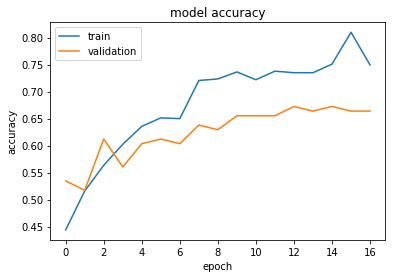

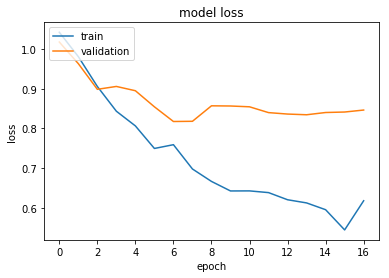

Time passed for training 93.6175651550293
train_indices[:5] [0 1 2 3 4] train_indices[-5:] [805 806 807 808 809]
val_indices[:5] [ 9 18 38 75 84] val_indices[-5:] [779 783 789 796 804]

class_weights [0.71 1.84 0.96]
class_to_index {0: 0, -1: 1, 1: 2}

TRAIN size: 694 	 VAL size: 116
Train label distribution:  label
-1    126
 0    328
 1    240
Name: label, dtype: int64
Val label distribution:  label
-1    21
 0    50
 1    45
Name: label, dtype: int64
Train on 694 samples, validate on 116 samples
Epoch 1/100
694/694 [==============================] - 6s 9ms/step - loss: 1.0540 - acc: 0.4424 - val_loss: 1.0115 - val_acc: 0.4483
Epoch 2/100
694/694 [==============================] - 5s 7ms/step - loss: 0.9973 - acc: 0.5086 - val_loss: 0.9589 - val_acc: 0.5517
Epoch 3/100
694/694 [==============================] - 5s 7ms/step - loss: 0.9412 - acc: 0.5562 - val_loss: 0.9153 - val_acc: 0.5000
Epoch 4/100
694/694 [==============================] - 5s 7ms/step - loss: 0.8863 - acc: 0.5908 -

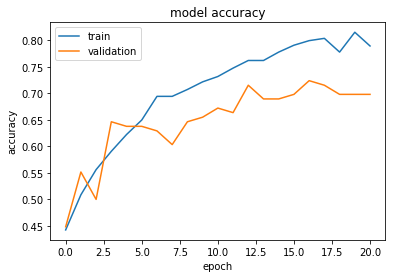

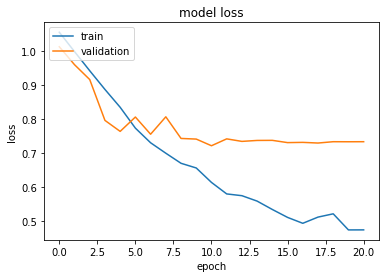

Time passed for training 113.4723711013794
train_indices[:5] [1 2 3 4 5] train_indices[-5:] [805 806 807 808 809]
val_indices[:5] [ 0  7  8 16 32] val_indices[-5:] [778 792 794 802 803]

class_weights [0.73 1.82 0.92]
class_to_index {0: 0, -1: 1, 1: 2}

TRAIN size: 694 	 VAL size: 116
Train label distribution:  label
-1    127
 0    315
 1    252
Name: label, dtype: int64
Val label distribution:  label
-1    20
 0    63
 1    33
Name: label, dtype: int64
Train on 694 samples, validate on 116 samples
Epoch 1/100
694/694 [==============================] - 6s 9ms/step - loss: 1.0380 - acc: 0.4424 - val_loss: 0.9765 - val_acc: 0.5517
Epoch 2/100
694/694 [==============================] - 5s 7ms/step - loss: 0.9912 - acc: 0.5403 - val_loss: 0.9450 - val_acc: 0.5603
Epoch 3/100
694/694 [==============================] - 5s 7ms/step - loss: 0.9191 - acc: 0.5648 - val_loss: 0.9063 - val_acc: 0.5172
Epoch 4/100
694/694 [==============================] - 5s 7ms/step - loss: 0.8760 - acc: 0.5980 

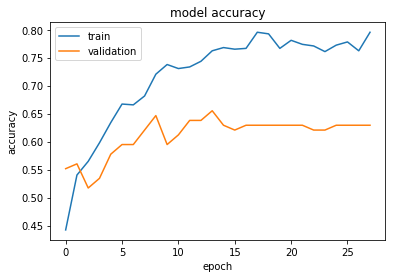

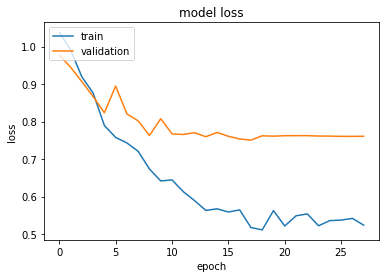

Time passed for training 150.21853470802307
train_indices[:5] [0 1 2 3 4] train_indices[-5:] [802 803 804 807 809]
val_indices[:5] [ 5 12 13 14 19] val_indices[-5:] [753 790 805 806 808]

class_weights [0.73 1.75 0.95]
class_to_index {0: 0, -1: 1, 1: 2}

TRAIN size: 694 	 VAL size: 116
Train label distribution:  label
-1    132
 0    319
 1    243
Name: label, dtype: int64
Val label distribution:  label
-1    15
 0    59
 1    42
Name: label, dtype: int64
Train on 694 samples, validate on 116 samples
Epoch 1/100
694/694 [==============================] - 6s 9ms/step - loss: 1.0442 - acc: 0.4496 - val_loss: 0.9572 - val_acc: 0.5431
Epoch 2/100
694/694 [==============================] - 5s 7ms/step - loss: 0.9746 - acc: 0.5476 - val_loss: 0.8898 - val_acc: 0.6207
Epoch 3/100
694/694 [==============================] - 5s 7ms/step - loss: 0.8985 - acc: 0.5692 - val_loss: 0.8040 - val_acc: 0.6552
Epoch 4/100
694/694 [==============================] - 5s 7ms/step - loss: 0.8198 - acc: 0.6282

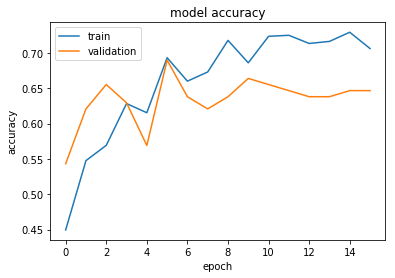

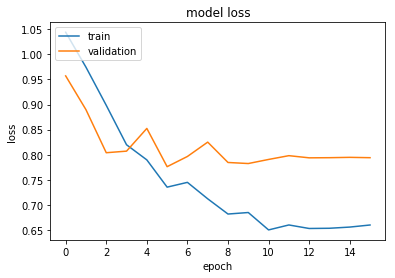

Time passed for training 91.65531277656555
train_indices[:5] [0 1 2 3 4] train_indices[-5:] [805 806 807 808 809]
val_indices[:5] [ 6 10 11 15 24] val_indices[-5:] [774 776 786 787 798]

class_weights [0.71 1.93 0.93]
class_to_index {0: 0, -1: 1, 1: 2}

TRAIN size: 694 	 VAL size: 116
Train label distribution:  label
-1    120
 0    326
 1    248
Name: label, dtype: int64
Val label distribution:  label
-1    27
 0    52
 1    37
Name: label, dtype: int64
Train on 694 samples, validate on 116 samples
Epoch 1/100
694/694 [==============================] - 6s 9ms/step - loss: 1.0490 - acc: 0.4553 - val_loss: 1.0450 - val_acc: 0.4569
Epoch 2/100
694/694 [==============================] - 5s 7ms/step - loss: 0.9894 - acc: 0.4957 - val_loss: 0.9980 - val_acc: 0.5172
Epoch 3/100
694/694 [==============================] - 5s 7ms/step - loss: 0.9444 - acc: 0.5447 - val_loss: 0.9234 - val_acc: 0.5172
Epoch 4/100
694/694 [==============================] - 5s 7ms/step - loss: 0.8427 - acc: 0.6239 

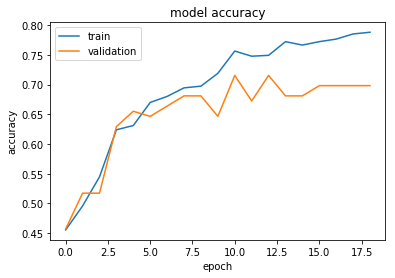

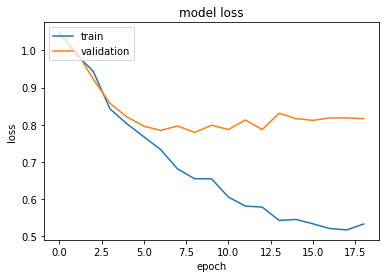

Time passed for training 105.70367574691772
train_indices[:5] [0 2 4 5 6] train_indices[-5:] [803 804 805 806 808]
val_indices[:5] [ 1  3 17 21 27] val_indices[-5:] [781 788 799 807 809]

class_weights [0.72 1.81 0.95]
class_to_index {0: 0, -1: 1, 1: 2}

TRAIN size: 695 	 VAL size: 115
Train label distribution:  label
-1    128
 0    322
 1    245
Name: label, dtype: int64
Val label distribution:  label
-1    19
 0    56
 1    40
Name: label, dtype: int64
Train on 695 samples, validate on 115 samples
Epoch 1/100
695/695 [==============================] - 7s 9ms/step - loss: 1.0574 - acc: 0.4345 - val_loss: 0.9930 - val_acc: 0.4870
Epoch 2/100
695/695 [==============================] - 5s 7ms/step - loss: 0.9869 - acc: 0.5079 - val_loss: 0.9573 - val_acc: 0.4870
Epoch 3/100
695/695 [==============================] - 5s 8ms/step - loss: 0.9242 - acc: 0.5655 - val_loss: 0.8958 - val_acc: 0.5913
Epoch 4/100
695/695 [==============================] - 5s 7ms/step - loss: 0.8309 - acc: 0.6432

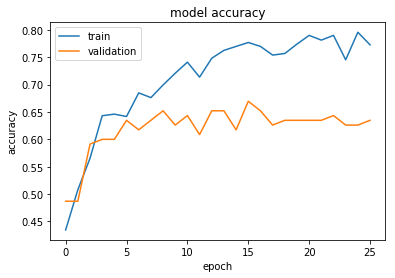

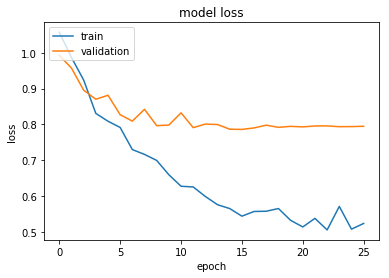

Time passed for training 147.16620016098022
train_indices[:5] [0 1 3 5 6] train_indices[-5:] [805 806 807 808 809]
val_indices[:5] [ 2  4 28 31 43] val_indices[-5:] [782 784 785 793 797]

class_weights [0.7  0.96 1.87]
class_to_index {0: 0, 1: 1, -1: 2}

TRAIN size: 695 	 VAL size: 115
Train label distribution:  label
-1    124
 0    330
 1    241
Name: label, dtype: int64
Val label distribution:  label
-1    23
 0    48
 1    44
Name: label, dtype: int64
Train on 695 samples, validate on 115 samples
Epoch 1/100
695/695 [==============================] - 6s 9ms/step - loss: 1.0480 - acc: 0.4446 - val_loss: 1.0348 - val_acc: 0.4174
Epoch 2/100
695/695 [==============================] - 5s 7ms/step - loss: 0.9927 - acc: 0.5094 - val_loss: 0.9850 - val_acc: 0.5217
Epoch 3/100
695/695 [==============================] - 5s 7ms/step - loss: 0.9448 - acc: 0.5281 - val_loss: 0.8997 - val_acc: 0.5652
Epoch 4/100
695/695 [==============================] - 5s 7ms/step - loss: 0.8490 - acc: 0.6245

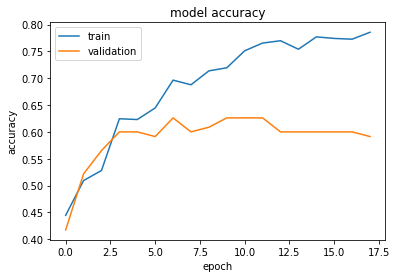

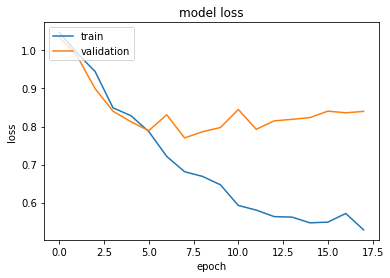

Time passed for training 104.20017075538635
Cross-validation val accuracy results:  [0.6724137931034483, 0.7241379310344828, 0.6551724137931034, 0.6896551724137931, 0.7155172413793104, 0.6695652179096057, 0.6260869567808898]
Cross-validation val accuracy results: 0.68% (+/- 0.03%)

 Cross-validation val f1 results:  []
Cross-validation val f1 results: nan% (+/- nan%)
max_seq_len 38
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_8 (Masking)          (None, None, 200)         0         
_________________________________________________________________
lstm_15 (LSTM)               (None, None, 38)          36328     
_________________________________________________________________
lstm_16 (LSTM)               (None, 38)                11704     
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 117       
Total params: 48,149


/home/elkhand/anaconda3/envs/cs231n/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/elkhand/anaconda3/envs/cs231n/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/elkhand/anaconda3/envs/cs231n/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/elkhand/anaconda3/envs/cs231n/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/elkhand/anaconda3/envs/cs231n/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


90/90 [==============================] - 0s 1ms/step
['loss', 'acc'] [0.6330479555659824, 0.7333333373069764]
90/90 [==============================] - 1s 12ms/step
cnf_matrix [[ 8  8  0]
 [ 4 32  6]
 [ 0  6 26]]


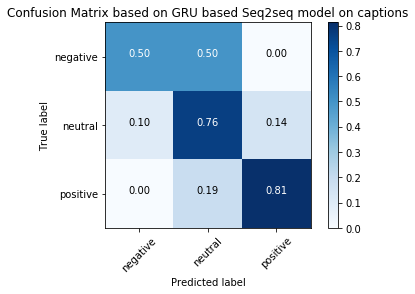

bald man head wooden table. grasps empty liquor bottle right hand. shot glass seen behind left arm. TL -1 PL 0
swimmer pool lane markers turning head take breath swimming. TL 1 PL 0
pigeon ground seeds scattered around it. TL 0 PL -1
sunset small cemetery. TL 0 PL 1
brown dog sitting garden path. mouth open mottled tongue hanging out. chain collar around neck. TL 1 PL 0
weasel sitting upright like human being. TL 0 PL -1
black white photo woman sitting ground one hand face top head. TL -1 PL 0
pasta salad olives tomatoes TL 0 PL 1
white dog running across grass ears flying. TL 1 PL 0
man's hand, holding black white bird. TL 0 PL -1
dog leash mouth open, looking alertly towards camera. TL 1 PL 0
black white photo man camouflage uniform holding assault rifle. TL 0 PL -1
brown dog paws nose fence looking it. TL -1 PL 0
three boys playing refugee camp tents behind them. TL 0 PL 1
gray black striped cat stares much larger dog white muzzle brown black fur. TL 0 PL 1
leafless tree, covered sn

In [15]:
def build_model(max_seq_len, num_of_classes, config): 
    # Cross-validation results: 0.61% (+/- 0.13%)
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(None, config['embedding_dimension'])))

#     model.add(Bidirectional(GRU(max_seq_len, return_sequences=True, dropout=config['dropout'],
#                                 recurrent_dropout=config['recurrent_dropout']), merge_mode='concat'))
#     model.add(Bidirectional(GRU(max_seq_len, dropout=config['dropout'] - 0.1, 
#                                 recurrent_dropout=config['recurrent_dropout'] - 0.1 ), merge_mode='concat'))    
    model.add(LSTM(max_seq_len, return_sequences=True, dropout=config['dropout'], recurrent_dropout=config['recurrent_dropout'])) 
    model.add(LSTM(max_seq_len, dropout=config['dropout'], recurrent_dropout=config['recurrent_dropout'])) 
    model.add(Dense(num_of_classes, activation='softmax'))
    
    if config['useF1Score']:
        metrics = ['accuracy', sc.f1, sc.recall, sc.precision]
    else:
        metrics = ['accuracy']
        

    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                      metrics=metrics)
    #print(model.summary())
    return model




def evalaute_on_test_data(model, testDataset, inputDataset, wordToVec, config):
    max_seq_len = int(testDataset['caption'].map(lambda x: caput.get_non_stop_word_count(x.split())).max())
    print("max_seq_len", max_seq_len)
    num_of_classes, class_to_index, index_to_class = caput.get_label_map_from_train_set(inputDataset, wordToVec, max_seq_len, config)
    X_test, y_test_index, _, _, _  = caput.load_dataset_StratifiedKFold(testDataset,wordToVec,max_seq_len,class_to_index, index_to_class, config)
    y_test = caput.convert_index_to_one_hot(y_test_index, num_of_classes) 
    print(model.summary())
    results = model.evaluate(X_test, y_test, verbose=1) # batch_size=1,
    print(model.metrics_names, results)
        
    predictions = model.predict(X_test, verbose=1)    
    predictionClasses = imut.conver_predictions_to_classes(predictions, class_to_index)
    y_test_classes = [index_to_class[k] for k in y_test_index]
    y_true = y_test_classes
    y_pred = predictionClasses
    
    
    cnf_matrix = confusion_matrix(y_true, y_pred)
    print("cnf_matrix", cnf_matrix)
    titleOfConfusionMatrix = "Confusion Matrix based on GRU based Seq2seq model on captions"
    pt.plot_confusion_matrix_from_labels(y_true, y_pred, titleOfConfusionMatrix)
    misLabeledCount = 0
    for index, row in testDataset.iterrows():
        caption = row['caption']
        label = row['label']
        if label != y_true[index]:
            print(caption)
            raise "Unexpected result, truth labels should have matched, seems the order is messed up"
        if label != y_pred[index]:
            print(caption,"TL", label,"PL", y_pred[index])
            misLabeledCount += 1 
    print("\n")
    print("Mislabeled count: ", misLabeledCount)


def train_StratifiedKFold(inputDataset, testDataset, wordToVec, config):
    """StratifiedKFold cross-validation"""
    # Shuffle dataset
    df = shuffle(inputDataset)
    X = df["caption"]
    y = df["label"]
    print("Label distribution: ",df.groupby('label').label.count())
    max_seq_len = int(df['caption'].map(lambda x: caput.get_non_stop_word_count(x.split())).max())
    print("max_seq_len", max_seq_len)
    
    # Instantiate the cross validator
    skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)
    cv_accuracies = []
    cv_f1s = []
    
    best_model = None
    best_model_best_acc = -1
    
    # Loop through the indices the split() method returns
    for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
        print("train_indices[:5]", train_indices[:5],"train_indices[-5:]",train_indices[-5:])
        print("val_indices[:5]", val_indices[:5],"val_indices[-5:]",val_indices[-5:])
        print()
        
        
        start = time.time()        
        class_to_index = {}
        index_to_class = {}
        
        X_train_caption, X_val_caption = X[train_indices], X[val_indices]
        y_train_index, y_val_index = y[train_indices], y[val_indices]
        
        dfTrain = pd.concat([X_train_caption, y_train_index], axis=1)
        dfTrain.columns = ['caption', 'label']
        X_train, y_train_index, num_of_classes, class_to_index, index_to_class = \
            caput.load_dataset_StratifiedKFold(
                            dfTrain,
                            wordToVec, 
                            max_seq_len, 
                            class_to_index, 
                            index_to_class,
                            config)
        y_train = caput.convert_index_to_one_hot(y_train_index, num_of_classes) 
        
        y_ints = [y.argmax() for y in y_train]
        class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_ints),
                                                 y_ints)
        print("class_weights", class_weights)
        print("class_to_index", class_to_index)
        
        dfVal= pd.concat([X_val_caption, y_val_index], axis=1)
        dfVal.columns = ['caption', 'label']
        X_val, y_val_index, _, _, _ = caput.load_dataset_StratifiedKFold(
                            dfVal,
                            wordToVec,
                            max_seq_len, 
                            class_to_index, 
                            index_to_class,
                            config)
        y_val = caput.convert_index_to_one_hot(y_val_index, num_of_classes) 
        
        
        print("\nTRAIN size:", len(train_indices), "\t VAL size:", len(val_indices))
        print("Train label distribution: ",dfTrain.groupby('label').label.count())
        print("Val label distribution: ",dfVal.groupby('label').label.count())

        
        model = build_model(max_seq_len,num_of_classes, config)
        
        plot_model(model, to_file = model_results_root_dir + '/model.png', show_shapes=True, show_layer_names=True)#
        
        
        # Log to tensorboard
        tensorBoardCallback = TensorBoard(log_dir=model_results_root_dir + '/logs', write_graph=True)
        
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.5, 
                                  patience=2, 
                                  min_lr=1e-7,
                                  cooldown=1,
                                  verbose=1)
        
        history = {}
        filename = ""
        # checkpoint
        filepath= model_results_root_dir + "/weights.best.h5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
        
        callbacks_list = [checkpoint,  reduce_lr, early_stopping, tensorBoardCallback]  # 
        
        history = model.fit(x=X_train,
                      y=y_train, 
                      batch_size=config['batch_size'],
                      epochs=config['nb_epochs'], 
                      verbose=config['verbose'], 
                      validation_data = (X_val, y_val),
                      shuffle=True,
                      callbacks=callbacks_list,
                      class_weight = class_weights)        # 
        val_acc_list = history.history['val_acc']
        best_val_acc =  max(val_acc_list)
        cv_accuracies.append(best_val_acc)
        print("best_val_acc: ", best_val_acc)
        
        if config['useF1Score']:
            val_f1_list = history.history['val_f1']
            best_f1 =  max(val_f1_list)
            print("best_f1: ", best_f1)
            cv_f1s.append(best_f1)
        
        filename = "caption" 
        filename = model_results_root_dir + caput.generate_model_name(filename, best_val_acc) + ".h5"
        os.rename(filepath, filename)
        
        pt.plot_model_accuracy(history,model_results_root_dir, config['useF1Score'])
        
        end = time.time()
        print("Time passed for training", (end-start))
        
        if best_val_acc > best_model_best_acc:
            best_model_best_acc = best_val_acc
            best_model = model
    
    print("=========================================")
    print("Cross-validation val accuracy results: " , cv_accuracies)
    print("Cross-validation val accuracy results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_accuracies), np.std(cv_accuracies)))
    
    print("\n","Cross-validation val f1 results: " , cv_f1s)
    print("Cross-validation val f1 results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_f1s), np.std(cv_f1s)))
    
    best_model.save(model_results_root_dir + "/bestmodel-" + str(best_model_best_acc) + ".h5")
    return best_model


def get_config():
    conf = {}
    conf["kfold_splits"] = kfold_splits
    conf["batch_size"] = batch_size
    conf['embedding_dimension'] = embedding_dimension
    conf['recurrent_dropout'] = recurrent_dropout
    conf['dropout'] = dropout
    conf["nb_epochs"] = nb_epochs
    conf['useF1Score'] = useF1Score
    conf['verbose'] = verbose
    conf['useF1Score'] = useF1Score
    conf['seed'] = seed
    return conf    
    
best_model = None
def main():
    global wordToVec, best_model
    config = get_config()
    print("config:\n", config)
    if wordToVec is None:
        wordToVec = load_embedding(fasttext_embedding_path)
    print("# words: ", len(wordToVec.keys())," word vector dimension", len(wordToVec[list(wordToVec.keys())[1]]))
    best_model = train_StratifiedKFold(inputDataset, testDataset, wordToVec, config)
    # Evaluate Test data set
    evalaute_on_test_data(best_model, testDataset, inputDataset, wordToVec, config)
    pass

if __name__ == "__main__":
    # execute only if run as a script
    main()

## Determien Vocabulary size - unique word counts

In [ ]:
df = pd.read_csv(dataset_path, header=0, sep="|")
df["caption"] = df["caption"].apply(lambda x: " ".join(caput.get_words_withoutstopwords(x.lower().split())))
vocabulary = set()
for index, row in df.iterrows():
    caption = row['caption']
    words = caption.lower().split()
    for word in words:
        vocabulary.add(word)
    
print("Voc size: ",len(vocabulary))    